In [2]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [3]:
dpe = DPE('COM6')

Connecting to serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected


In [4]:
dpe.set_clock(50)

Connecting to serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [5]:
g = dpe.read(1)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


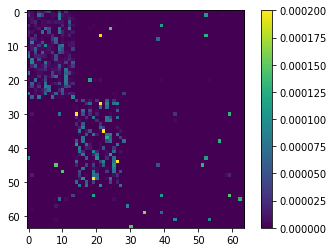

In [6]:
plt.imshow(g)
plt.clim(0, 2e-4)
plt.colorbar()

In [6]:
nn = NN_dpe(weights)

In [7]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [57]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2

Connecting to serial
[INFO] Elapsed time = 1.44s
Serial disconnected


In [58]:
outputs.shape

(400, 14)

In [64]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

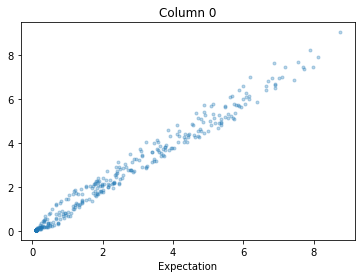

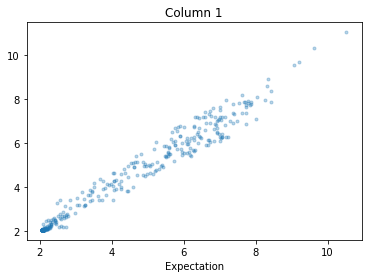

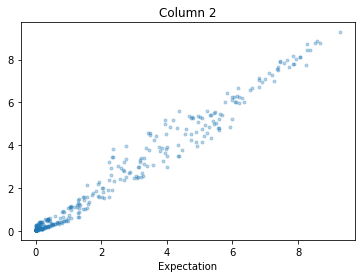

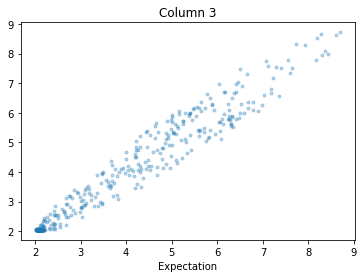

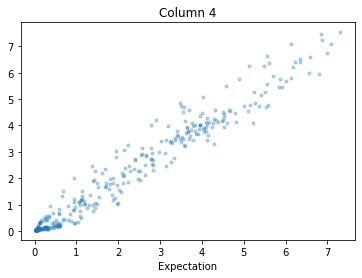

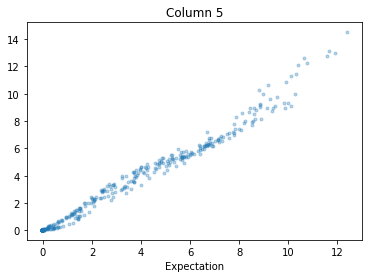

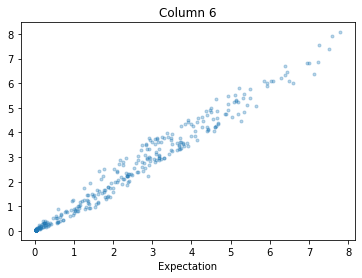

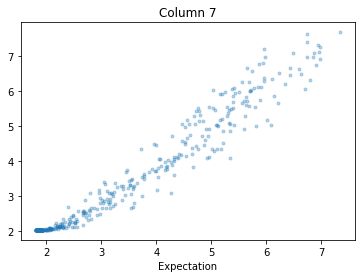

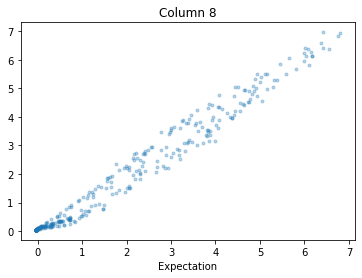

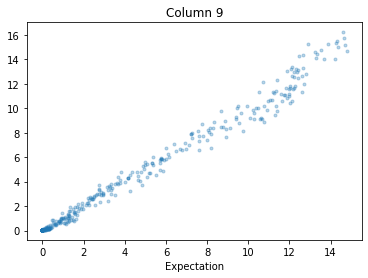

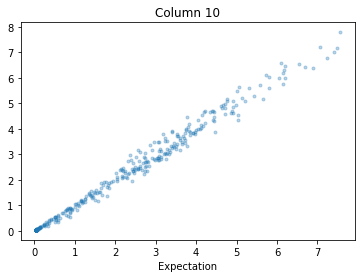

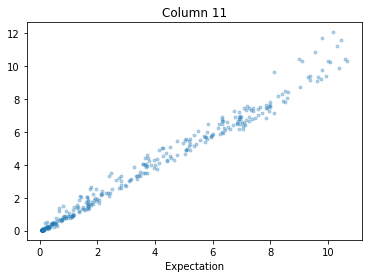

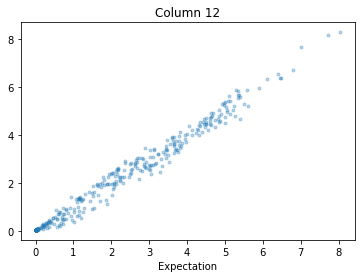

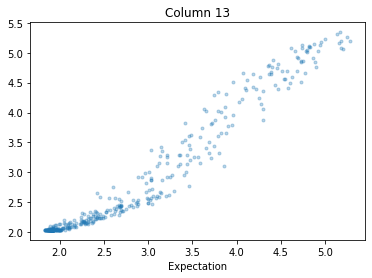

In [70]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

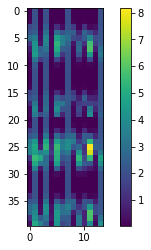

In [66]:
plt.imshow(software[:40])
plt.colorbar()

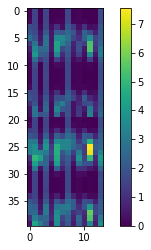

In [67]:
plt.imshow(outputs[:40])
plt.colorbar()

In [68]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 1.13749449,  0.01358634],
       [ 1.03591099,  0.50379678],
       [ 1.24174482,  0.00276059],
       [ 1.17516357,  0.21569485],
       [ 1.18427323, -0.01955403],
       [ 1.12108096, -0.07177681],
       [ 1.11373491, -0.06541175],
       [ 1.25309867, -0.17633366],
       [ 1.12341981, -0.09598089],
       [ 1.34701148, -0.15000297],
       [ 1.10853803,  0.00718064],
       [ 1.09053429,  0.05159966],
       [ 1.11826596,  0.00490957],
       [ 0.89964305,  0.40773342]])

In [69]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [45]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [46]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [71]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

idx=9999, predicted: 6, label: 6
	 Accuracy = 97.09%
Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'list'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), to 20190821-051552-mnist_xs.pkl
Saving In(<class 'list'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_

In [229]:
load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [230]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [209]:
xs

array([[ 1.25553929, -0.        ,  3.46783397, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        ,  2.12042721,  5.09473203, ..., -0.        ,
         5.05506579,  4.01159157],
       [-0.        , -0.        ,  0.08640882, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.08640882, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.08640882, ..., -0.        ,
         0.07088482, -0.        ],
       [-0.        , -0.        ,  0.92241658, ..., -0.        ,
         5.3060081 ,  2.80420645]])

In [162]:
xs = np.array(xs)
xs.shape

(10000, 112)

In [163]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [164]:
xs.shape

(10000, 113)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


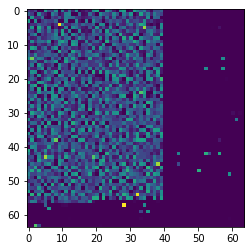

In [179]:
plt.imshow(dpe.read(2))

In [180]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [199]:
output1 = dpe.multiply(2, x1, c_sel=[0, 20])
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(2, x2, c_sel=[20, 40])
software2 = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 2.02s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 2.05s
Serial disconnected


In [200]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [201]:
lin_cor_fc2

[array([1.53865650e+01, 1.47278844e-05]),
 array([ 1.69131542e+01, -4.40594517e-05]),
 array([ 1.79023697e+01, -1.69631381e-04]),
 array([ 1.75786094e+01, -1.27245071e-04]),
 array([ 1.59597027e+01, -6.91056533e-05]),
 array([ 1.72623775e+01, -1.20186382e-04]),
 array([ 1.78896863e+01, -1.01659363e-04]),
 array([ 1.83484469e+01, -3.51288320e-05]),
 array([1.54813073e+01, 2.79418701e-05]),
 array([ 1.66125467e+01, -1.50676933e-04]),
 array([ 1.84016846e+01, -2.42807677e-05]),
 array([ 1.66674679e+01, -9.72936438e-05]),
 array([ 1.69821016e+01, -2.13764006e-05]),
 array([ 1.69729711e+01, -1.32714655e-05]),
 array([1.43618496e+01, 1.03719499e-04]),
 array([1.57889747e+01, 2.77955029e-05]),
 array([1.80304259e+01, 2.11617111e-05]),
 array([ 1.87735438e+01, -2.31479535e-04]),
 array([1.53217480e+01, 1.76921589e-05]),
 array([ 1.70640601e+01, -1.73841261e-04])]

In [190]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

Connecting to serial
[INFO] Elapsed time = 2.02s
Serial disconnected


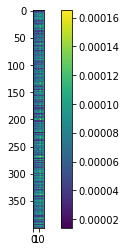

In [191]:
outputs  = dpe.multiply(2, x1, c_sel=[0, 20])
plt.imshow(outputs)
plt.colorbar()
outputs = lin_corr(outputs, lin_cor_fc1)

In [14]:
# lin_cor_fc1 = [
#        [ 1.65705364e+01, -4.76661730e-06],
#        [ 1.52014391e+01, -7.32910667e-06],
#        [ 1.83622860e+01, -1.03660227e-04],
#        [ 1.46453131e+01,  8.72582481e-05],
#        [ 1.57026572e+01,  5.49433331e-06],
#        [ 1.75302910e+01, -5.91984363e-05],
#        [ 1.70097444e+01, -3.77425017e-06],
#        [ 1.66811834e+01, -5.92705383e-05],
#        [ 1.58138030e+01, -8.54206565e-05],
#        [ 1.47224922e+01, -1.01580546e-04],
#        [ 1.63933874e+01,  2.75899701e-05],
#        [ 1.73734414e+01, -6.44827939e-05],
#        [ 1.72284591e+01, -1.78498676e-05],
#        [ 1.56514926e+01,  4.85230992e-05],
#        [ 1.82551529e+01, -6.58699418e-05],
#        [ 1.80427640e+01,  3.35214924e-05],
#        [ 1.68846215e+01,  5.83922590e-05],
#        [ 1.78382218e+01, -5.84954866e-05],
#        [ 1.59426072e+01, -2.58419590e-05],
#        [ 1.77145924e+01, -3.09111781e-04]]

# lin_cor_fc2 = [
#        [ 1.49074642e+01,  3.04496037e-05],
#        [ 1.66134607e+01, -6.65273335e-05],
#        [ 1.71330302e+01, -1.16174943e-04],
#        [ 1.70197025e+01, -5.26536591e-05],
#        [ 1.57107974e+01, -7.15197241e-05],
#        [ 1.70294047e+01, -7.92741963e-05],
#        [ 1.73580128e+01, -7.60909714e-05],
#        [ 1.84105096e+01, -2.43281137e-05],
#        [ 1.68061704e+01, -2.11947699e-05],
#        [ 1.51725578e+01, -2.68254150e-05],
#        [ 1.85076350e+01, -3.41438100e-05],
#        [ 1.60115486e+01, -3.91897704e-05],
#        [ 1.56633900e+01,  5.07271500e-05],
#        [ 1.78045219e+01, -8.48122737e-05],
#        [ 1.53011229e+01,  6.33155863e-05],
#        [ 1.49990127e+01,  8.11595510e-05],
#        [ 1.75060714e+01,  4.32311953e-05],
#        [ 1.79812969e+01, -1.50383469e-04],
#        [ 1.58391025e+01,  3.87391613e-06],
#        [ 1.58795906e+01, -1.12594198e-04]]

In [139]:
output1  = dpe.multiply(2, x1, c_sel=[0, 20]) 
output1 = lin_corr(output1, lin_cor_fc1)

output2  = dpe.multiply(2, x2, c_sel=[20, 40])
output2 = lin_corr(output2, lin_cor_fc2)

outputs = output1 + output2

Connecting to serial
[INFO] Elapsed time = 2.00s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 2.00s
Serial disconnected


In [202]:
outputs = dpe.multiply(2, x2, c_sel=[20, 40]) 
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 1.91s
Serial disconnected


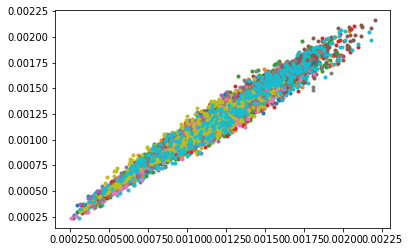

In [204]:
lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = outputs[:,c]
    
    plt.plot(x,y,'.')

    lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([  1.,   2.,   1.,   1.,   4.,  10.,  13.,  17.,  25.,  33.,  51.,
         55.,  84.,  93., 116., 118., 183., 216., 251., 314., 364., 397.,
        459., 447., 518., 592., 561., 499., 446., 419., 374., 291., 245.,
        207., 150., 110., 112.,  62.,  56.,  39.,  22.,  20.,  11.,   5.,
          2.,   2.,   0.,   1.,   0.,   1.]),
 array([-0.11460966, -0.11004209, -0.10547453, -0.10090696, -0.09633939,
        -0.09177183, -0.08720426, -0.08263669, -0.07806912, -0.07350156,
        -0.06893399, -0.06436642, -0.05979886, -0.05523129, -0.05066372,
        -0.04609615, -0.04152859, -0.03696102, -0.03239345, -0.02782589,
        -0.02325832, -0.01869075, -0.01412318, -0.00955562, -0.00498805,
        -0.00042048,  0.00414708,  0.00871465,  0.01328222,  0.01784979,
         0.02241735,  0.02698492,  0.03155249,  0.03612005,  0.04068762,
         0.04525519,  0.04982276,  0.05439032,  0.05895789,  0.06352546,
         0.06809302,  0.07266059,  0.07722816,  0.08179573,  0.08636329,
 

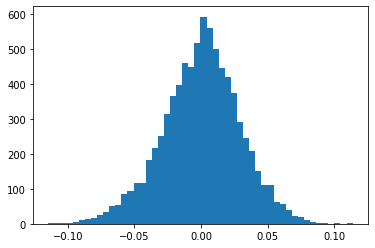

In [174]:
plt.hist((outputs-software).reshape(-1, 1)/0.0025, bins=50 )

In [175]:
(outputs-software).reshape(-1, 1).std()/0.0025

0.02893208430610786

In [18]:
# lin_cor_fc1 = [
#        [ 1.65705364e+01, -4.76661730e-06],
#        [ 1.52014391e+01, -7.32910667e-06],
#        [ 1.83622860e+01, -1.03660227e-04],
#        [ 1.46453131e+01,  8.72582481e-05],
#        [ 1.57026572e+01,  5.49433331e-06],
#        [ 1.75302910e+01, -5.91984363e-05],
#        [ 1.70097444e+01, -3.77425017e-06],
#        [ 1.66811834e+01, -5.92705383e-05],
#        [ 1.58138030e+01, -8.54206565e-05],
#        [ 1.47224922e+01, -1.01580546e-04],
#        [ 1.63933874e+01,  2.75899701e-05],
#        [ 1.73734414e+01, -6.44827939e-05],
#        [ 1.72284591e+01, -1.78498676e-05],
#        [ 1.56514926e+01,  4.85230992e-05],
#        [ 1.82551529e+01, -6.58699418e-05],
#        [ 1.80427640e+01,  3.35214924e-05],
#        [ 1.68846215e+01,  5.83922590e-05],
#        [ 1.78382218e+01, -5.84954866e-05],
#        [ 1.59426072e+01, -2.58419590e-05],
#        [ 1.77145924e+01, -3.09111781e-04]]

# lin_cor_fc2 = [
#        [ 1.49074642e+01,  3.04496037e-05],
#        [ 1.66134607e+01, -6.65273335e-05],
#        [ 1.71330302e+01, -1.16174943e-04],
#        [ 1.70197025e+01, -5.26536591e-05],
#        [ 1.57107974e+01, -7.15197241e-05],
#        [ 1.70294047e+01, -7.92741963e-05],
#        [ 1.73580128e+01, -7.60909714e-05],
#        [ 1.84105096e+01, -2.43281137e-05],
#        [ 1.68061704e+01, -2.11947699e-05],
#        [ 1.51725578e+01, -2.68254150e-05],
#        [ 1.85076350e+01, -3.41438100e-05],
#        [ 1.60115486e+01, -3.91897704e-05],
#        [ 1.56633900e+01,  5.07271500e-05],
#        [ 1.78045219e+01, -8.48122737e-05],
#        [ 1.53011229e+01,  6.33155863e-05],
#        [ 1.49990127e+01,  8.11595510e-05],
#        [ 1.75060714e+01,  4.32311953e-05],
#        [ 1.79812969e+01, -1.50383469e-04],
#        [ 1.58391025e+01,  3.87391613e-06],
#        [ 1.58795906e+01, -1.12594198e-04]]

def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [16]:
load_workspace(vars(), '20190821-051552-mnist_xs')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, linear_factors_conv, c, x, i, result, x1, y, xs, acc, 


In [205]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[i*1000:(i+1)*1000]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20])
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40])
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    
ys = np.concatenate(ys)  

Accuracy = 60.50%
Running on sample 1000-2000
Connecting to serial


KeyboardInterrupt: 

In [128]:
np.mean(ys.argmax(axis=1) == test_labels)

0.2773

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [18]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

(26, 14)

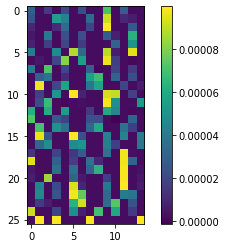

In [19]:
plt.imshow(finalGconv)
plt.colorbar()
np.shape(finalGconv)

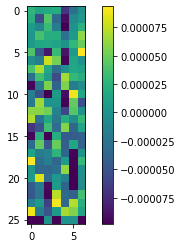

In [22]:
g1 = finalGconv[:,::2] - finalGconv[:,1::2]
plt.imshow(g1)
plt.colorbar()

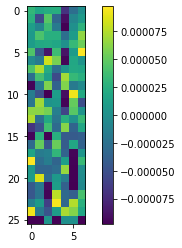

In [24]:
g2 = nn.Gconv[:,::2] - nn.Gconv[:,1::2]
plt.imshow(g2/2)
plt.colorbar()

(array([-5.0e-07,  0.0e+00,  5.0e-07,  1.0e-06,  1.5e-06,  2.0e-06,
         2.5e-06,  3.0e-06,  3.5e-06,  4.0e-06,  4.5e-06]),
 <a list of 11 Text xticklabel objects>)

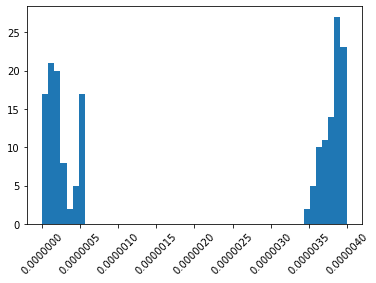

In [31]:
plt.hist((g2/2-g1).reshape(-1,1), bins=50)
plt.xticks(rotation=45)

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *
vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)